# Analysis of Kai's DEER data

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os,re

In [2]:
from pathlib import Path
#os.getcwd()
dir_path = './KaisData/PulsedESR/OneDrive_1_6-10-2021'
def getdata(filename: Path):
    fstr = str(filename.resolve())
    try:
        fh = open(fstr)
    except IOError:
        print("File not found or path is incorrect")
        raise
    data = np.genfromtxt(filename,delimiter='\t')
    # get the signal and reference
    tempsig = data[:,0]
    tempref = data[:,1]
    #process the metadata file
    metadatfile = fstr.split(".txt")[0]+".log"
    mfilehandle=open(metadatfile)
    mdata = mfilehandle.readlines()
    mfilehandle.close()
    numavgs=int(mdata[3].split('\r\n')[0])
    timestart=float(mdata[1].split('\r\n')[0].split(',')[0].split('[')[1])
    timestop=float(mdata[1].split('\r\n')[0].split(',')[2].split(']')[0])
    timestep=float(mdata[1].split('\r\n')[0].split(',')[1])
    numpoints=mdata[4].split('\t').__len__()-1

    # the signal and refernce arrays need to be partitioned into lists
    # that are have numavg rows and numpoints columns
    tempsig = np.array_split(tempsig, numavgs)
    tempref = np.array_split(tempref, numavgs)
    #average along the rows
    signal = np.average(tempsig,axis=0)
    reference = np.average(tempref,axis=0)
    meanref = np.mean(reference)
    #calculate errors in signal and reference and then the x and y data
    sigerr=np.sqrt(signal)
    referr = np.sqrt(reference)
    #xdata = np.linspace(timestart,timestep*len(signal),len(signal))
    xdata = np.fromstring(mdata[-1],sep='\t')  # it appears Kai saves the x array into the last element of mdata
    ydata = (signal - reference)/meanref + 1.0
    #error bar calculation is not perfect yet, error in meanref needs to
    #be taken into account
    errb = np.sqrt(sigerr**2 + referr**2)/meanref/np.sqrt(numavgs)
    # plt.errorbar(xdata,ydata,yerr=errb,fmt='o')
    # plt.show()
    return xdata,ydata,errb

# create a generator that will walk the directory tree structure
def walk(path:Path): 
    for p in Path(path).iterdir(): 
        if p.is_dir(): 
            yield from walk(p)
            continue
        yield p.resolve()

def listlogfiles(directory:str): 
    # recursively traverse all files from current directory
    print("--------------log files in {}--------".format(directory))
    listlog = []
    for p in walk(Path(directory)): 
        if '.log' in str(p.name):
            print(p.name)
            # the function returns a generator so if you need a list you need to build one
            listlog.append(str(p.name))
    listlog.sort()
    return listlog



def getlogparams(filename:str):
    '''returns the logfile parameters in a tuple (navgs, npoints, mwdict, xdata)
    :param navgs: the number of averages
    :param npoints: the number of points
    :param mwdict: a dictionary that contains all the parameters used for the microwave sources
    :param xdata: an array that contains the data points of the x-axis for the scan
    '''
    #fstr = str(filename.resolve())
    fstr = str(filename)
    try:
        fh = open(Path(fstr))
    except IOError:
        print("File not found or path is incorrect")
        raise
    data = np.genfromtxt(Path(fstr),delimiter='\t')
    # get the signal and reference
    tempsig = data[:,0]
    tempref = data[:,1]
    #process the metadata file
    metadatfile = fstr.split(".txt")[0]+".log"
    mfilehandle=open(metadatfile)
    mdata = mfilehandle.readlines()
    mfilehandle.close()
    numavgs=int(mdata[3].split('\r\n')[0])
    timestart=float(mdata[1].split('\r\n')[0].split(',')[0].split('[')[1])
    timestop=float(mdata[1].split('\r\n')[0].split(',')[2].split(']')[0])
    timestep=float(mdata[1].split('\r\n')[0].split(',')[1])
    numpoints=mdata[4].split('\t').__len__()-1
    # get the dictionary object that contains all the MW information
    mwdict = eval(mdata[2]) 
    xdata = np.fromstring(mdata[-1],sep='\t')# it appears Kai saves the x array into the last element of mdata
    # the other params are the samples, count and reset time etc
    #params = np.fromstring(mdata[0],sep=',')
    return numavgs,numpoints,mwdict,xdata

def getdatfilenames(directory:str):
    """Gets all the filenames for data files"""
    datfiles = []
    tracklogfiles = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            datfiles.append(directory+os.sep+filename)
        elif filename.endswith('_tracklog.txt'):
            tracklogfiles.append(directory+os.sep+filename)
            # print(os.path.join(directory, filename))
        else:
            continue
    datfiles.sort()
    tracklogfiles.sort()
    justdatfiles = list(set(datfiles) - set(tracklogfiles))
    return justdatfiles

def getmatchfiles(fnames:str,pattern:str):
    """Returns all the filenames that contain a matching pattern string"""
    matchfs = [fnames[i] for i in range(len(fnames)) if fnames[i].count(pattern)]
    matchfs.sort()
    return matchfs

def plotsingledatafile(file:str,**kwargs):
    '''Plots the data in a file
    :param file: the path for the data file
    :param xaxis: kwarg string that gives the label for the x-axis
    :param yaxis: kwarg string that gives label for y-axis '''
    x1,y1,y1errb = getdata(Path(file))
    navgs,npts,mwdict,xdat=getlogparams(file)
    newdic = dict([])
    for k,v in kwargs.items():
        newdic[k] = v
    mpl.rcParams['text.usetex']=True
    x_plot = np.linspace(x1[0],x1[-1],100)
    namestr = re.split('.txt',re.split('/',file)[-1])[0] 
    f=plt.figure()
    plt.errorbar(x1,y1,yerr=y1errb,fmt='o-',label=namestr)
    plt.xlabel(newdic['xaxis'])
    plt.ylabel(newdic['yaxis'])
    plt.legend()
    plt.xlim(x1[0],x1[-1])
    ymax = np.amax(y1)
    ymin = np.amin(y1)
    #print('ymax = {0},ymin = {1}'.format(ymax,ymin))
    plt.ylim(ymin-0.025,ymax+0.025)
    plt.show()
    return f

def plotmatchdatafiles(directory:str,pattern:str,**kwargs):
    """Plots all the data from the matching data files in a table
    :param directory: Path to directory
    :param pattern: string which contains pattern to match
    :param plotcols: keyword arg integer for number of plot columns
    :param plotrows: kword arg integer for number of plot rows
    :param xaxis: kwarg string that gives the label for the x-axis
    :param yaxis: kwarg string that gives label for y-axis '''"""
    
    kwargdic = dict([])
    for k,v in kwargs.items():
        kwargdic[k] = v
    xaxis = kwargdic['xaxis']
    yaxis = kwargdic['yaxis']
    plotrows = kwargdic['plotrows']
    plotcols = kwargdic['plotcols']
    datfiles = getmatchfiles(getdatfilenames(directory),pattern)
    fig,ax = plt.subplots(plotrows,plotcols,figsize=(11,8),squeeze=False)
    # this loop goes through the list of data files and adds the output of
    # renorm function to a big matrix that contains all the data
    # there has to be a faster way of doing this using for loops maybe but this works for now.
    idx = 0
    mpl.rcParams['text.usetex'] = 'True'

    for i in range(plotrows):
        for j in range(plotcols):
            idx = i*plotcols + j
            if idx > (len(datfiles)-1):
                break
            else:
                # get the name of the file without the separator and .txt
                x1, y1,yerrb = getdata(Path(datfiles[idx]))
                filestr = re.split('.txt',re.split('/',datfiles[idx])[-1])[0] 

                navgs,npts,mwdict,xdat=getlogparams(datfiles[idx]) 
                ax[i,j].errorbar(x1,y1,yerr=yerrb,fmt='o-',label=filestr)
                #ax[i,j].set_title(filestr)
                ax[i,j].set_xlabel(xaxis)   
                ax[i,j].set_ylabel(yaxis)
                ax[i,j].legend(loc=0)
                ax[i,j].set_xlim(x1[0],x1[-1])
                ymax = np.amax(y1)
                ymin = np.amin(y1)
                ax[i][j].set_ylim(ymin-0.025,ymax+0.025)
            
    plt.show()
    return fig,ax

## NV1 data taken 2017-10-03 to 2017-10-06

**NV1 is likely an implanted NV as only 2 peaks are seen in the ODMR scan**

In [6]:
# testing kwarg unpacking
def tfunc(**kwargs):
    adic = dict([])
    for k,v in kwargs.items():
        print(k,'->',v)
        adic[k]=v
    return adic
tfunc(n=1,t=2)

n -> 1
t -> 2


{'n': 1, 't': 2}

## Data from 2017-10-03

In [21]:
datadir = dir_path + '/'+'2017-10-03'
flist = listlogfiles(datadir)
#print(getdatfilenames(datadir))

--------------log files in ./KaisData/PulsedESR/OneDrive_1_6-10-2021/2017-10-03--------
Rabi2.log
Rabi1.log
BDEER2.log
BDEER3.log
BDEER1.log
BDEER4.log
600freqscan.log
BDEER5.log
echo4.log
echo1.log
2000freqscan.log
echo3.log
echo2.log


In [22]:
n,p,d,x= getlogparams(datadir+'/echo1.txt')
print("The NV resonance frequency used was {} GHz".format(d['USB'][1]))

The NV resonance frequency used was 2.4745 GHz


<ErrorbarContainer object of 3 artists>

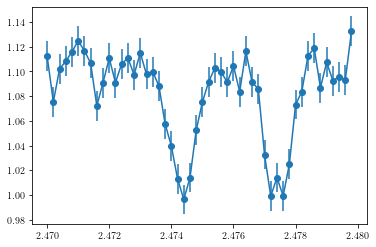

In [23]:
datadir = dir_path + '/'+'2017-10-03'
f = datadir + '/2000freqscan.txt'
x1,y1,y1errb = getdata(Path(f))
x_plot = np.linspace(x1[0],x1[-1],100)
plt.errorbar(x1,y1,yerr=y1errb,fmt='o-')

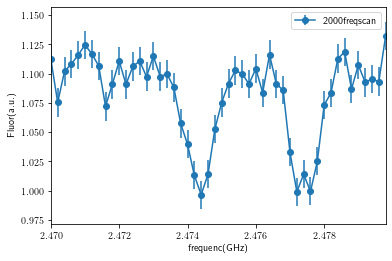

In [24]:
fg = plotsingledatafile(f,xaxis=r'frequenc(GHz)',yaxis=r'Fluor(a.u.)')

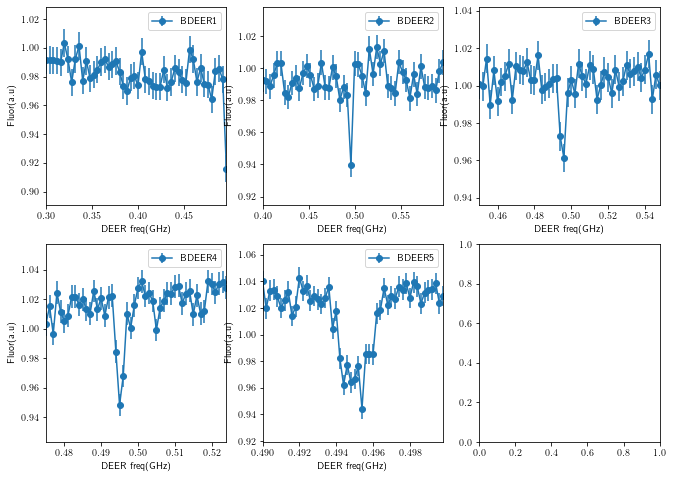

In [25]:
fig,axs = plotmatchdatafiles(datadir,'DEER',xaxis=r'DEER freq(GHz)',yaxis='Fluor(a.u)',plotrows=2,plotcols=3)

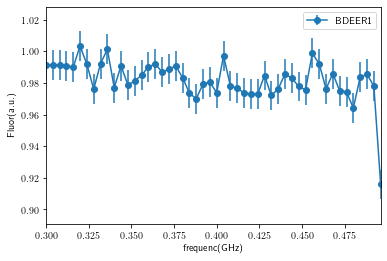

In [253]:
f = datadir + '/BDEER1.txt'
fg = plotsingledatafile(f,xaxis=r'frequenc(GHz)',yaxis=r'Fluor(a.u.)')

## Data from 2017-10-04

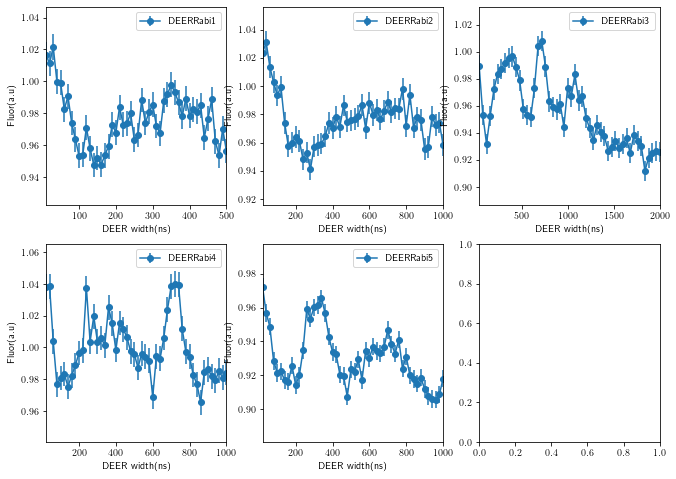

--------------log files in ./KaisData/PulsedESR/OneDrive_1_6-10-2021/2017-10-04--------
DEERRabi4.log
DEERRabi5.log
DEERRabi1.log
DEERRabi2.log
DEERRabi3.log
empty.log
bdeer1.log
echo1.log
echo2.log


In [254]:
datadir = dir_path + '/'+'2017-10-04'
fig,axs = plotmatchdatafiles(datadir,'DEER',xaxis=r'DEER width(ns)',yaxis='Fluor(a.u)',plotrows=2,plotcols=3)
flist = listlogfiles(datadir)

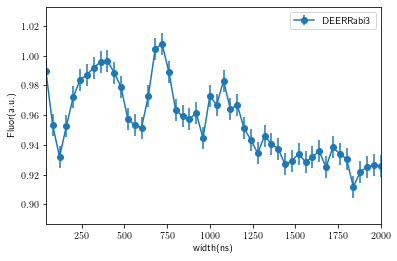

In [257]:
f = datadir + '/DEERRabi3.txt'
fg = plotsingledatafile(f,xaxis=r'width(ns)',yaxis=r'Fluor(a.u.)')

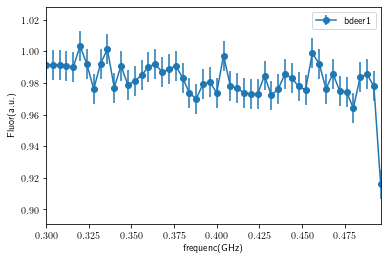

In [162]:
f = datadir + '/bdeer1.txt'
fg = plotsingledatafile(f,xaxis=r'frequenc(GHz)',yaxis=r'Fluor(a.u.)')

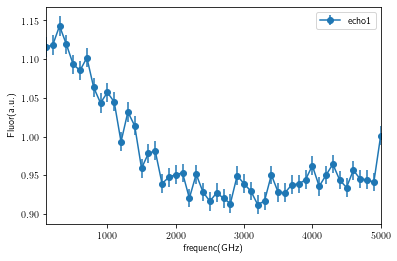

In [163]:
f = datadir + '/echo1.txt'
fg = plotsingledatafile(f,xaxis=r'frequenc(GHz)',yaxis=r'Fluor(a.u.)')

## Data from 2017-10-05

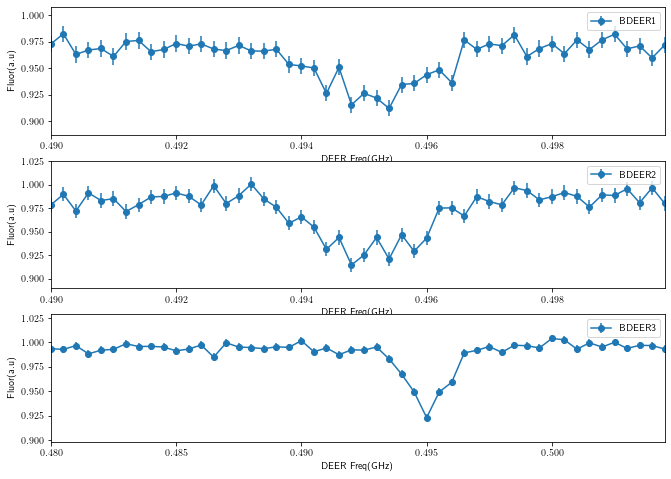

--------------log files in ./KaisData/PulsedESR/OneDrive_1_6-10-2021/2017-10-05--------
Rabi.log
deerrabi.log
BDEER2.log
BDEER3.log
BDEER1.log


In [26]:
datadir = dir_path + '/'+'2017-10-05'
fig,axs = plotmatchdatafiles(datadir,'DEER',xaxis=r'DEER Freq(GHz)',yaxis='Fluor(a.u)',plotrows=3,plotcols=1)
flist = listlogfiles(datadir)

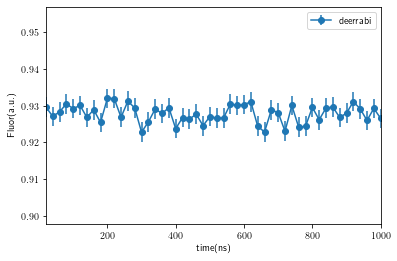

The DEER freq was 0.49500 Ghz and NV freq was 2.47450 GHz


In [29]:
f = datadir + '/deerrabi.txt'
fg = plotsingledatafile(f,xaxis=r'time(ns)',yaxis=r'Fluor(a.u.)')
a,b,c,d = getlogparams(f)
print('The DEER freq was {0:.5f} Ghz and NV freq was {1:.5f} GHz'.format(c['PTS'][1],c['USB'][1]))

## Data from 2017-10-06

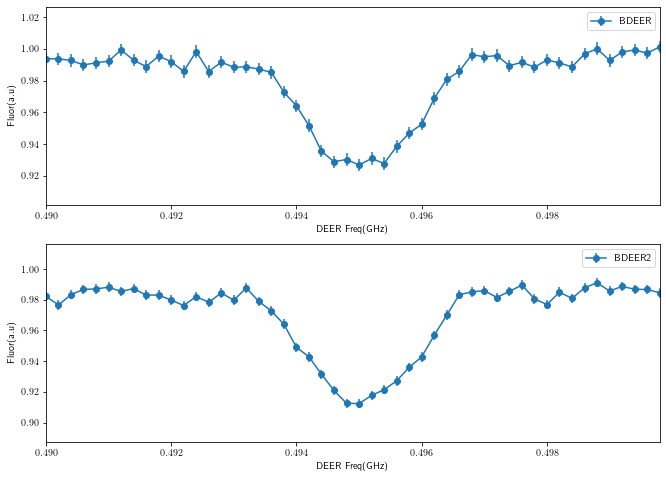

--------------log files in ./KaisData/PulsedESR/OneDrive_1_6-10-2021/2017-10-06--------
deerrabi4.log
deerrabi5.log
deerrabi1.log
deerrabi2.log
deerrabi3.log
BDEER.log
rabi.log
BDEER2.log
Echo.log
CP3.log
CP3_2.log


In [298]:
datadir = dir_path + '/'+'2017-10-06'
fig,axs = plotmatchdatafiles(datadir,'DEER',xaxis=r'DEER Freq(GHz)',yaxis='Fluor(a.u)',plotrows=2,plotcols=1)
flist = listlogfiles(datadir)

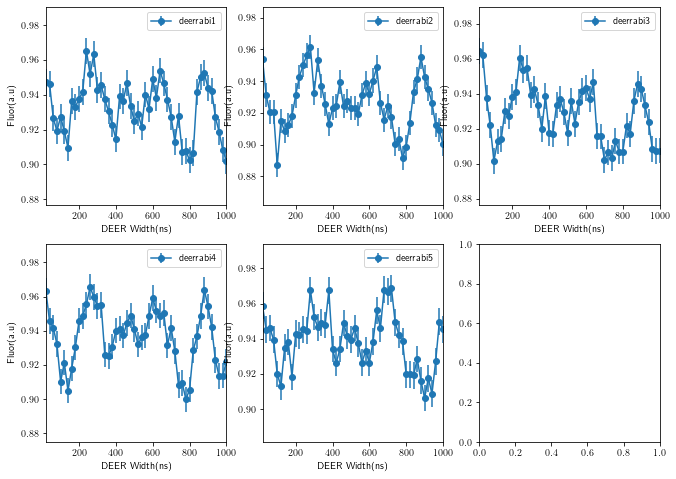

In [263]:
fig,axs = plotmatchdatafiles(datadir,'deer',xaxis=r'DEER Width(ns)',yaxis='Fluor(a.u)',plotrows=2,plotcols=3)

## NV2 data taken 2017-10-30 to 2017-11-17

**NV2 is likely a native N14 which is close to the surface since 3 resonances are observed in the fine ODMR scans.**

According to Kai, the 2nd and 3rd DEER peaks were found on 2017-11-08 and 2017-11-15. Data for DEER Rabi at the 2nd and 3rd peaks was taken 2017-11-08 and 2017-11-16. Also at NV2 , some other dips were found but failed to display DEER Rabi ,e g. on 2017-11-17 and 2017-11-18

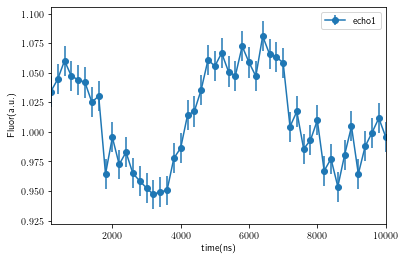

In [296]:
datadir = dir_path + '/'+'2017-10-30'
f = datadir + '/echo1.txt'
fg = plotsingledatafile(f,xaxis=r'time(ns)',yaxis=r'Fluor(a.u.)')

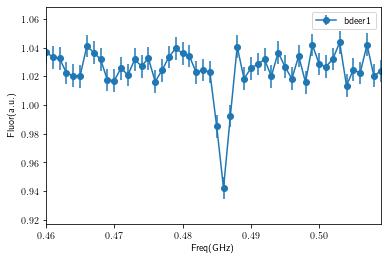

In [173]:
f = datadir + '/bdeer1.txt'
fg = plotsingledatafile(f,xaxis=r'Freq(GHz)',yaxis=r'Fluor(a.u.)')

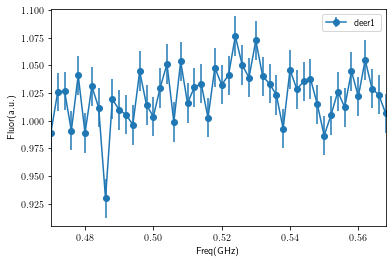

In [174]:
f = datadir + '/deer1.txt'
fg = plotsingledatafile(f,xaxis=r'Freq(GHz)',yaxis=r'Fluor(a.u.)')

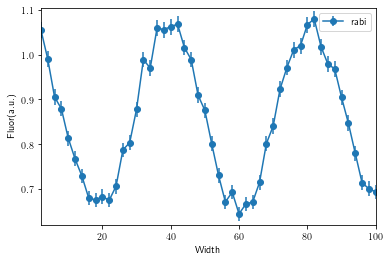

In [175]:
f = datadir + '/rabi.txt'
fg = plotsingledatafile(f,xaxis=r'Width',yaxis=r'Fluor(a.u.)')

In [176]:
flist =listlogfiles(datadir)

--------------log files in ./KaisData/PulsedESR/OneDrive_1_6-10-2021/2017-10-30--------
freqscan2000.log
rabi.log
freqscan600.log
bdeer1.log
deer1.log
echo1.log
echo2.log


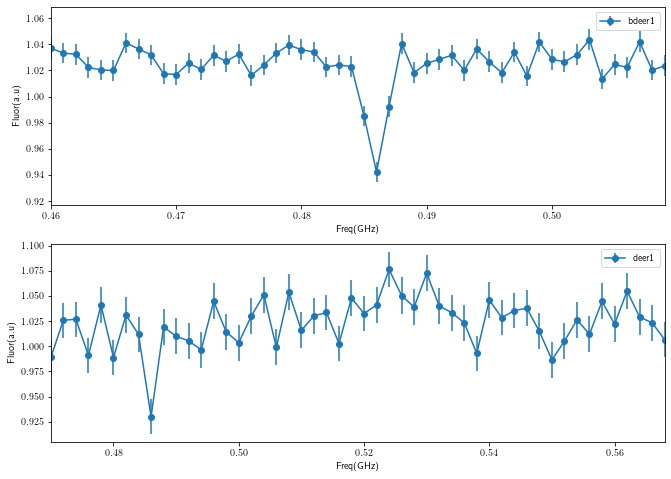

In [297]:
fig,axs = plotmatchdatafiles(datadir,'deer',xaxis=r'Freq(GHz)',yaxis='Fluor(a.u)',plotrows=2,plotcols=1)

## Data from 2017-11-01

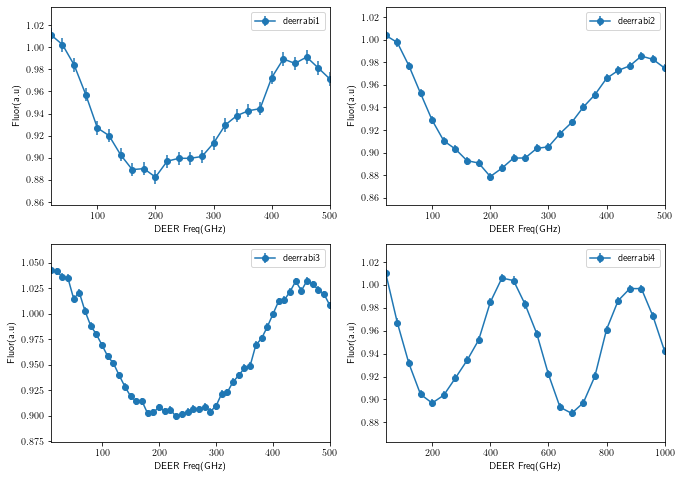

--------------log files in ./KaisData/PulsedESR/OneDrive_1_6-10-2021/2017-11-01--------
deerrabi4.log
deerrabi1.log
deerrabi2.log
deerrabi3.log
t1.log


In [268]:
datadir = dir_path + '/'+'2017-11-01'
fig,axs = plotmatchdatafiles(datadir,'deer',xaxis=r'DEER Freq(GHz)',yaxis='Fluor(a.u)',plotrows=2,plotcols=2)
flist = listlogfiles(datadir)
#print(flist)

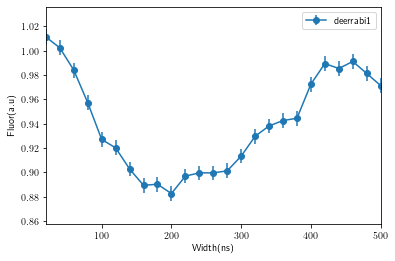

In [187]:
f = datadir + '/deerrabi1.txt'
fg = plotsingledatafile(f,xaxis = 'Width(ns)',yaxis=r'Fluor(a.u)')

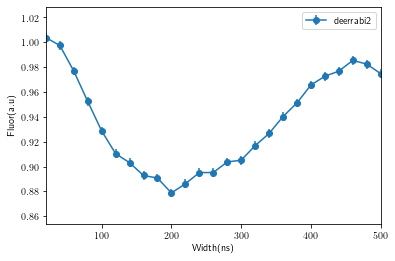

In [189]:
f = datadir + '/deerrabi2.txt'
fg = plotsingledatafile(f,xaxis = 'Width(ns)',yaxis=r'Fluor(a.u)')

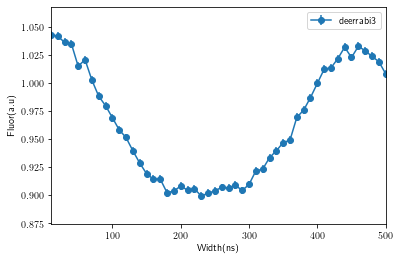

In [190]:
f = datadir + '/deerrabi3.txt'
fg = plotsingledatafile(f,xaxis = 'Width(ns)',yaxis=r'Fluor(a.u)')

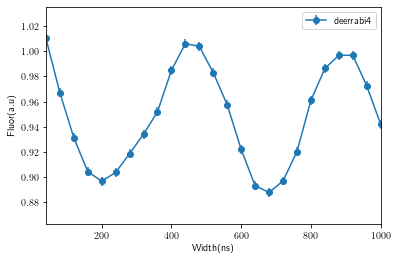

In [192]:
f = datadir + '/deerrabi4.txt'
fg = plotsingledatafile(f,xaxis = 'Width(ns)',yaxis=r'Fluor(a.u)')

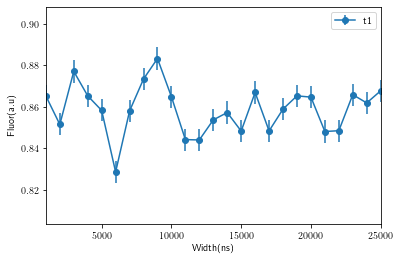

In [193]:
f = datadir + '/t1.txt'
fg = plotsingledatafile(f,xaxis = 'Width(ns)',yaxis=r'Fluor(a.u)')

## NV2 2017-11-02

In [269]:
datadir = dir_path + '/'+'2017-11-02'
flist = listlogfiles(datadir)

--------------log files in ./KaisData/PulsedESR/OneDrive_1_6-10-2021/2017-11-02--------
freqscan2000.log
rabi.log
sdeer1.log
Bdeer2.log
bdeer3.log
Bdeer1.log
DeerEcho.log
t1.log


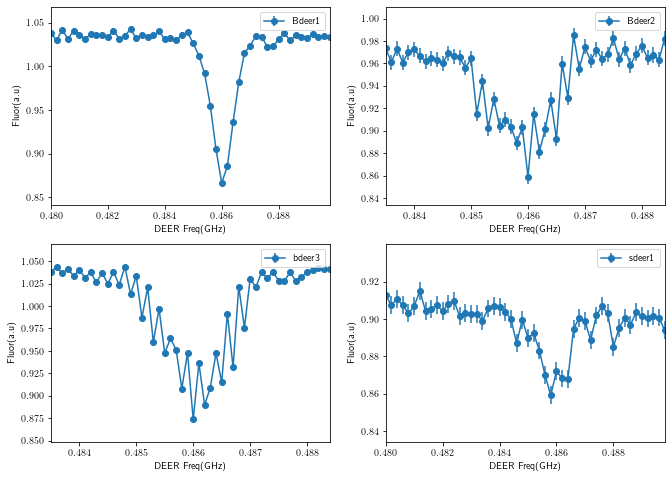

In [270]:
fig,axs = plotmatchdatafiles(datadir,'deer',xaxis=r'DEER Freq(GHz)',yaxis='Fluor(a.u)',plotrows=2,plotcols=2)

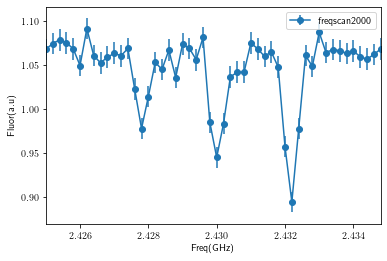

In [208]:
f = datadir + '/freqscan2000.txt'
fg = plotsingledatafile(f,xaxis = 'Freq(GHz)',yaxis=r'Fluor(a.u)')

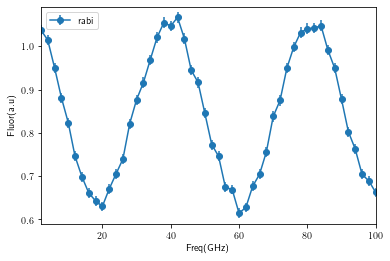

In [209]:
f = datadir + '/rabi.txt'
fg = plotsingledatafile(f,xaxis = 'Freq(GHz)',yaxis=r'Fluor(a.u)')

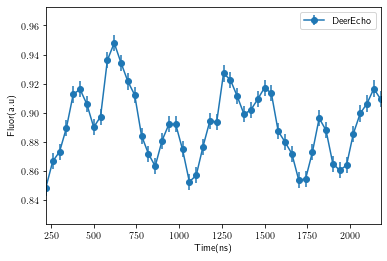

In [211]:
f = datadir + '/DeerEcho.txt'
fg = plotsingledatafile(f,xaxis = 'Time(ns)',yaxis=r'Fluor(a.u)')

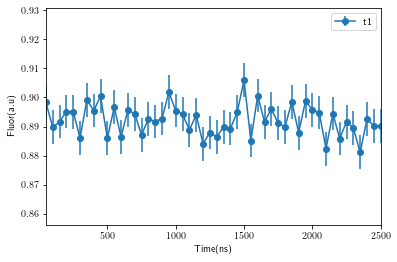

In [212]:
f = datadir + '/t1.txt'
fg = plotsingledatafile(f,xaxis = 'Time(ns)',yaxis=r'Fluor(a.u)')

## NV 2, 2017-11-03

In [271]:
datadir = dir_path + '/'+'2017-11-03'
flist = listlogfiles(datadir)

--------------log files in ./KaisData/PulsedESR/OneDrive_1_6-10-2021/2017-11-03--------
deerrabi4.log
deerrabi5.log
deerrabi2.log
deerrabi3.log
deerrabi.log
deerecho4.log
deerecho3.log
deerecho2.log
deerecho1.log


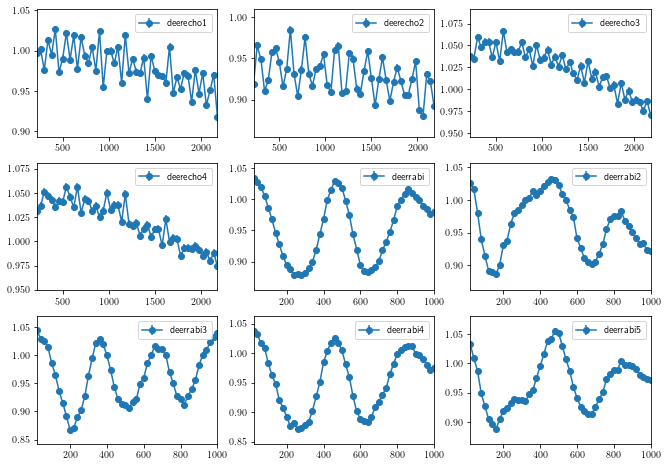

In [272]:
fig,axs = plotmatchdatafiles(datadir,'deer',xaxis=r'',yaxis='',plotrows=3,plotcols=3)

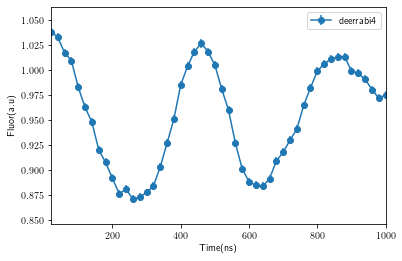

In [273]:
f = datadir + '/deerrabi4.txt'
fg = plotsingledatafile(f,xaxis = 'Time(ns)',yaxis=r'Fluor(a.u)')

## NV2 , 2017-11-04

In [274]:
datadir = dir_path + '/'+'2017-11-04'
flist = listlogfiles(datadir)

--------------log files in ./KaisData/PulsedESR/OneDrive_1_6-10-2021/2017-11-04--------
sdeer1.log
pulse1.log
sdeerrabi.log
deer1.log


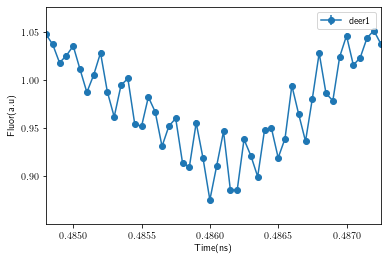

In [275]:
f = datadir + '/deer1.txt'
fg = plotsingledatafile(f,xaxis = 'Time(ns)',yaxis=r'Fluor(a.u)')

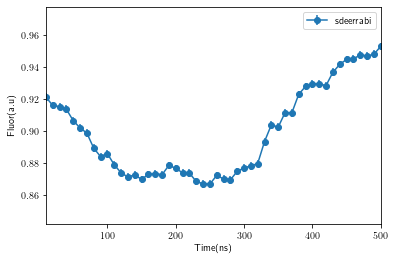

In [276]:
f = datadir + '/sdeerrabi.txt'
fg = plotsingledatafile(f,xaxis = 'Time(ns)',yaxis=r'Fluor(a.u)')

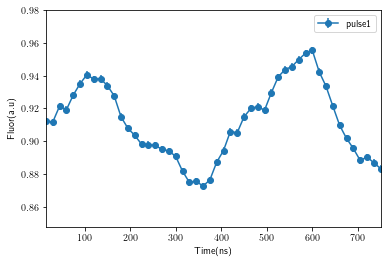

In [277]:
f = datadir + '/pulse1.txt'
fg = plotsingledatafile(f,xaxis = 'Time(ns)',yaxis=r'Fluor(a.u)')

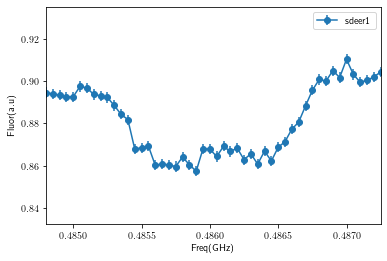

In [279]:
f = datadir + '/sdeer1.txt'
fg = plotsingledatafile(f,xaxis = 'Freq(GHz)',yaxis=r'Fluor(a.u)')

## NV2, 2017-11-05

In [280]:
datadir = dir_path + '/'+'2017-11-05'
flist = listlogfiles(datadir)

--------------log files in ./KaisData/PulsedESR/OneDrive_1_6-10-2021/2017-11-05--------


## NV2, 2017-11-06

In [284]:
datadir = dir_path + '/'+'2017-11-06'
flist = listlogfiles(datadir)

--------------log files in ./KaisData/PulsedESR/OneDrive_1_6-10-2021/2017-11-06--------
echo.log
deer.log


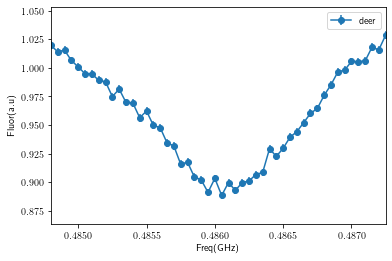

In [285]:
f = datadir + '/deer.txt'
fg = plotsingledatafile(f,xaxis = 'Freq(GHz)',yaxis=r'Fluor(a.u)')

## NV2, 2017-11-07

In [286]:
datadir = dir_path + '/'+'2017-11-07'
flist = listlogfiles(datadir)

--------------log files in ./KaisData/PulsedESR/OneDrive_1_6-10-2021/2017-11-07--------
deerrabi.log


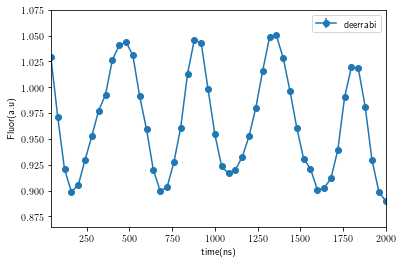

In [288]:
f = datadir + '/deerrabi.txt'
fg = plotsingledatafile(f,xaxis = 'time(ns)',yaxis=r'Fluor(a.u)')

## NV2, 2017-11-08

In [30]:
datadir = dir_path + '/'+'2017-11-08'
flist = listlogfiles(datadir)

--------------log files in ./KaisData/PulsedESR/OneDrive_1_6-10-2021/2017-11-08--------
deerrabi1.log
bdeer2.log
sdeer.log
bdeer3.log
bdeer1.log
bdeer4.log


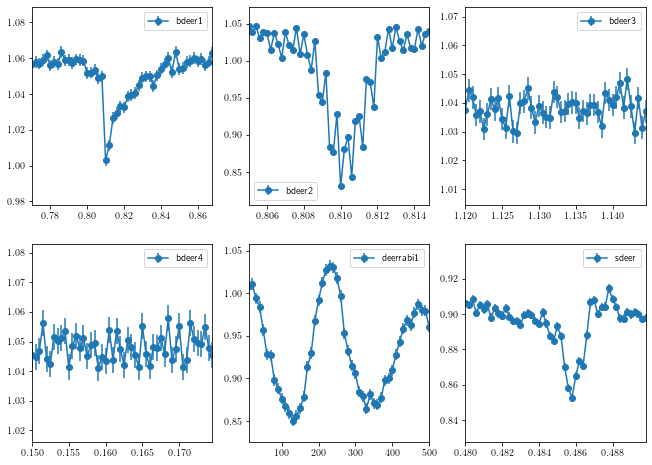

In [17]:
fig,axs = plotmatchdatafiles(datadir,'deer',xaxis=r'',yaxis='',plotrows=2,plotcols=3)

As mentioned above, DEER Rabi was taken at 810 MHz i.e. the 2nd DEER resonance. Just to check, we extract that file separately and its parameters

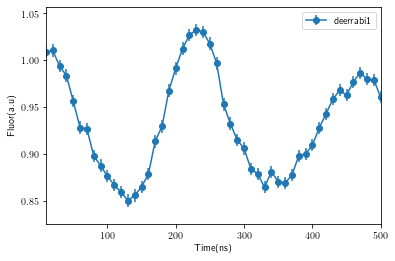

The DEER mw was tuned to 0.81000 GHz, NV was tuned to 2.43220 GHz


In [31]:
f = datadir + '/deerrabi1.txt'
fg = plotsingledatafile(f,xaxis = 'Time(ns)',yaxis=r'Fluor(a.u)')
a,b,c,d = getlogparams(f)
#print(a,b,c,d)
print("The DEER mw was tuned to {0:.5f} GHz, NV was tuned to {1:.5f} GHz".format(c['PTS'][1],c['USB'][1]))

In [32]:
fg.savefig("nv2_deerrabi_810Mhz.pdf",bbox_inches="tight")

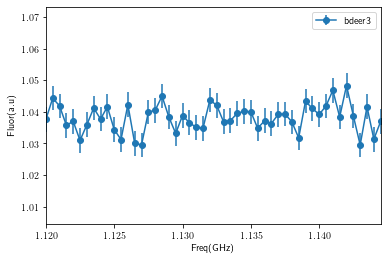

In [35]:
f = datadir + '/bdeer3.txt'
fg = plotsingledatafile(f,xaxis = 'Freq(GHz)',yaxis=r'Fluor(a.u)')
a,b,c,d = getlogparams(f)
#print(a,b,c,d)
#print("The DEER mw was tuned to {0:.5f} GHz, NV was tuned to {1:.5f} GHz".format(c['PTS'][1],c['USB'][1]))

Below we plot all 4 DEER frequency scans + one scan from 2017-11-16, to show that we did look at other ranges and found no resonances. 

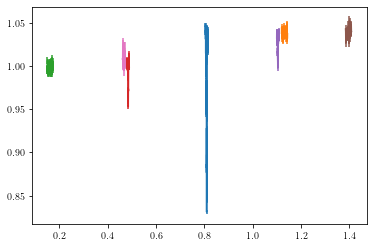

In [61]:
f1 = datadir + '/bdeer2.txt'
x1,y1,y1errb = getdata(Path(f1))
f2 = datadir + '/bdeer3.txt'
x2,y2,y2errb = getdata(Path(f2))
f3 = datadir + '/bdeer4.txt'
x3,y3,y3errb = getdata(Path(f3))
f4 = datadir + '/sdeer.txt'
x4,y4,y4errb = getdata(Path(f4))
f5 = dir_path + '/'+'2017-11-16' + '/deer1.txt'
x5,y5,y5errb = getdata(Path(f5))
f6 = dir_path + '/'+'2017-11-17' + '/deer2.txt'
x6,y6,y6errb = getdata(Path(f6))
f7 = dir_path + '/'+'2017-11-17' + '/deer3.txt'
x7,y7,y7errb = getdata(Path(f7))
f8 = dir_path + '/'+'2017-11-17' + '/deer6.txt'
x8,y8,y8errb = getdata(Path(f8))
fg = plt.figure()
plt.errorbar(x1,y1,y1errb)
plt.errorbar(x2,y2,y2errb)
plt.errorbar(x3,y3-0.05,y3errb)
plt.errorbar(x4,y4+0.1,y4errb)
plt.errorbar(x5,y5-0.02,y5errb)
plt.errorbar(x6,y6-0.02,y6errb)
plt.errorbar(x7,y7-0.05,y7errb)
#plt.errorbar(x8,y8-0.05,y8errb)
fg.savefig("nv2_deer_widerange1.pdf",bbox_inches="tight")

## NV2, 2017-11-09

In [302]:
datadir = dir_path + '/'+'2017-11-09'
flist = listlogfiles(datadir)

--------------log files in ./KaisData/PulsedESR/OneDrive_1_6-10-2021/2017-11-09--------
bdeer2.log
bdeer3.log
bdeer1.log


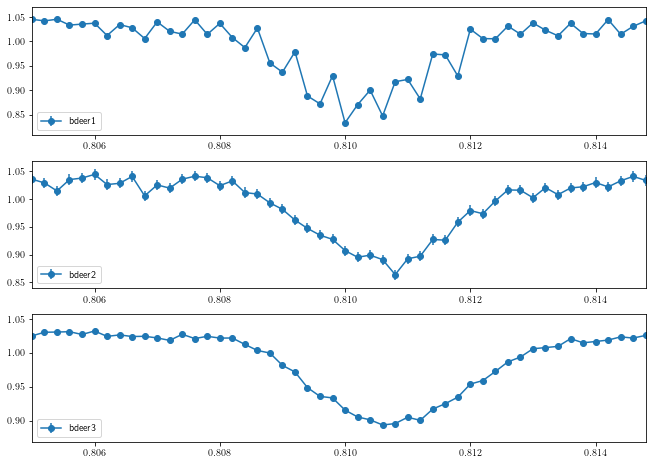

In [303]:
fig,axs = plotmatchdatafiles(datadir,'deer',xaxis=r'',yaxis='',plotrows=3,plotcols=1)

## NV2, 2017-11-10

In [304]:
datadir = dir_path + '/'+'2017-11-10'
flist = listlogfiles(datadir)

--------------log files in ./KaisData/PulsedESR/OneDrive_1_6-10-2021/2017-11-10--------
bdeer2.log
bdeer1.log


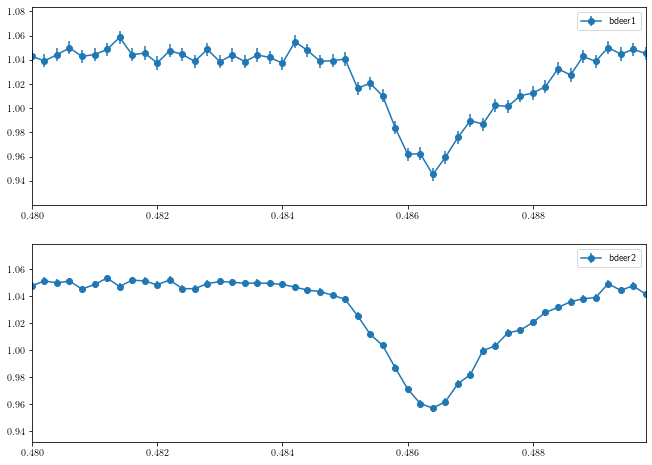

In [306]:
fig,axs = plotmatchdatafiles(datadir,'deer',xaxis=r'',yaxis='',plotrows=2,plotcols=1)

## NV2, 2017-11-11

In [307]:
datadir = dir_path + '/'+'2017-11-11'
flist = listlogfiles(datadir)

--------------log files in ./KaisData/PulsedESR/OneDrive_1_6-10-2021/2017-11-11--------


## NV2, 2017-11-14

In [308]:
datadir = dir_path + '/'+'2017-11-14'
flist = listlogfiles(datadir)

--------------log files in ./KaisData/PulsedESR/OneDrive_1_6-10-2021/2017-11-14--------
temp.log
freqscan2000.log
deer1.log
deer2.log


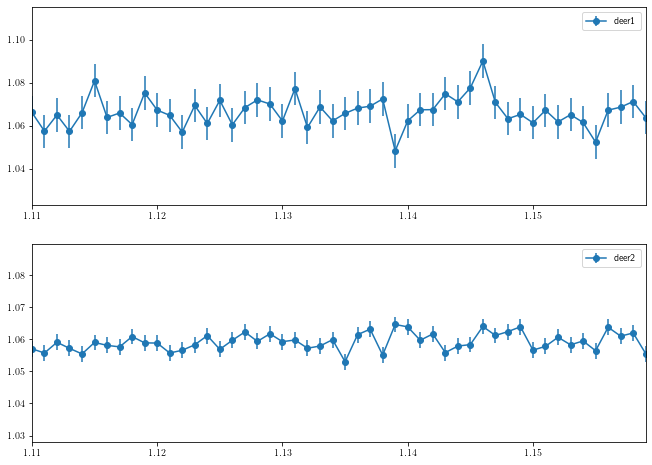

In [309]:
fig,axs = plotmatchdatafiles(datadir,'deer',xaxis=r'',yaxis='',plotrows=2,plotcols=1)

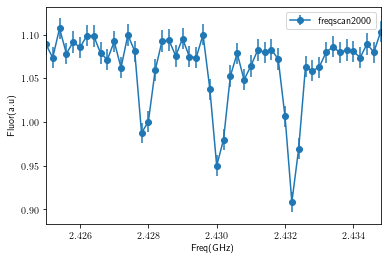

In [311]:
f = datadir + '/freqscan2000.txt'
fg = plotsingledatafile(f,xaxis = 'Freq(GHz)',yaxis=r'Fluor(a.u)')

## NV2, 2017-11-15

In [312]:
datadir = dir_path + '/'+'2017-11-15'
flist = listlogfiles(datadir)

--------------log files in ./KaisData/PulsedESR/OneDrive_1_6-10-2021/2017-11-15--------
deer1.log


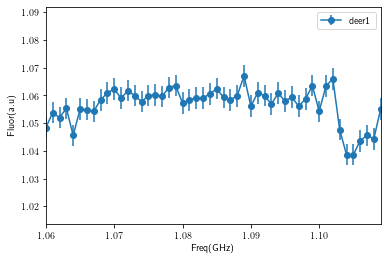

In [313]:
f = datadir + '/deer1.txt'
fg = plotsingledatafile(f,xaxis = 'Freq(GHz)',yaxis=r'Fluor(a.u)')

As seen above, this gives a hint of the 3rd DEER peak at 1.105 GHz, the data is repeated below and DEER rabi is also taken.

## NV2, 2017-11-16

In [62]:
datadir = dir_path + '/'+'2017-11-16'
flist = listlogfiles(datadir)

--------------log files in ./KaisData/PulsedESR/OneDrive_1_6-10-2021/2017-11-16--------
deerrabi1.log
rabi.log
deer1.log


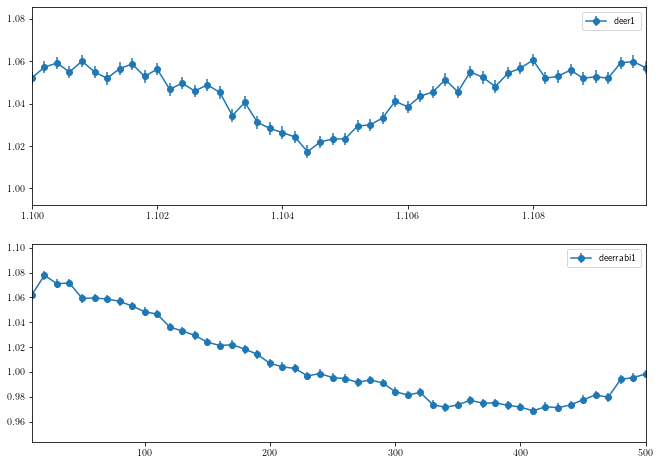

In [315]:
fig,axs = plotmatchdatafiles(datadir,'deer',xaxis=r'',yaxis='',plotrows=2,plotcols=1)

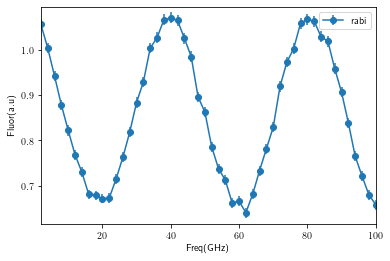

In [316]:
f = datadir + '/rabi.txt'
fg = plotsingledatafile(f,xaxis = 'Freq(GHz)',yaxis=r'Fluor(a.u)')

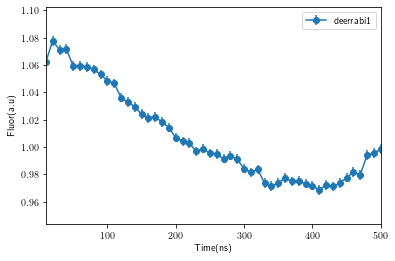

The DEER mw was tuned to 1.10450 GHz, NV was tuned to 2.43220 GHz


In [63]:
f = datadir + '/deerrabi1.txt'
fg = plotsingledatafile(f,xaxis = 'Time(ns)',yaxis=r'Fluor(a.u)')
a,b,c,d = getlogparams(f)
#print(a,b,c,d)
print("The DEER mw was tuned to {0:.5f} GHz, NV was tuned to {1:.5f} GHz".format(c['PTS'][1],c['USB'][1]))
fg.savefig("nv2_deerrabi_1104MHz.pdf",bbox_inches="tight")

## NV2, 2017-11-17

In [317]:
datadir = dir_path + '/'+'2017-11-17'
flist = listlogfiles(datadir)

--------------log files in ./KaisData/PulsedESR/OneDrive_1_6-10-2021/2017-11-17--------
deerrabi.log
deer6.log
deer5.log
deer4.log
deer1.log
deer3.log
deer2.log


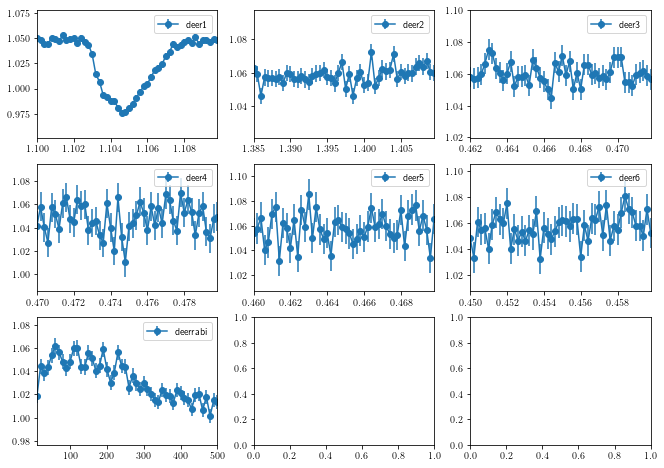

In [318]:
fig,axs = plotmatchdatafiles(datadir,'deer',xaxis=r'',yaxis='',plotrows=3,plotcols=3)

Some of the above data (deer2, deer3, deer4, deer5, deer6) might be useful to answer referee question of whether the DEER signal vanishes in certain conditions. 

Kai actually mentioned these as noted at the beginning of this section on NV2, that there are some places where there might be a dip but does not display DEER rabi.

## NV2, 2017-11-18

In [321]:
datadir = dir_path + '/'+'2017-11-18'
flist = listlogfiles(datadir)

--------------log files in ./KaisData/PulsedESR/OneDrive_1_6-10-2021/2017-11-18--------
deearabi.log


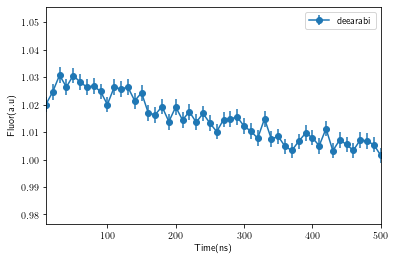

The DEER mw was tuned to 1.39800 GHz


In [327]:
f = datadir + '/deearabi.txt' # note that there was a typo in the filename 
fg = plotsingledatafile(f,xaxis = 'Time(ns)',yaxis=r'Fluor(a.u)')
a,b,c,d = getlogparams(f)
#print(a,b,c,d)
print("The DEER mw was tuned to {0:.5f} GHz".format(c['PTS'][1]))

## NV3 data taken after 2018-02-01

Kai said he thought there might be some good data here but he did not show in the paper

In [64]:
datadir = dir_path + '/'+'2018-02-01'
flist = listlogfiles(datadir)

--------------log files in ./KaisData/PulsedESR/OneDrive_1_6-10-2021/2018-02-01--------
spinecho1.log
spinecho2.log
spinecho3.log
spinecho5.log
deer1.log
deer2.log


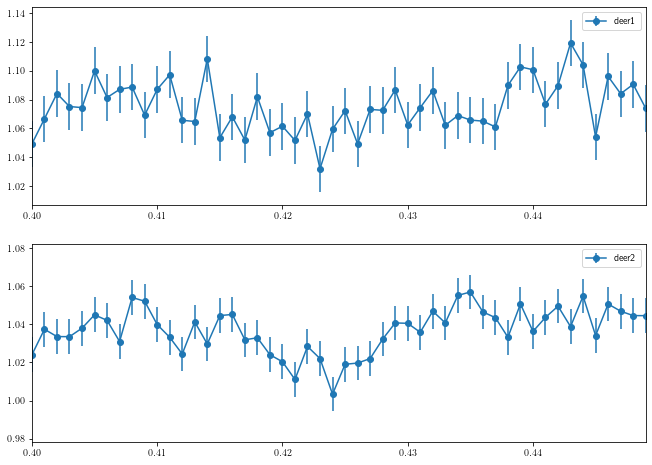

In [6]:
fig,axs = plotmatchdatafiles(datadir,'deer',xaxis=r'',yaxis='',plotrows=2,plotcols=1)

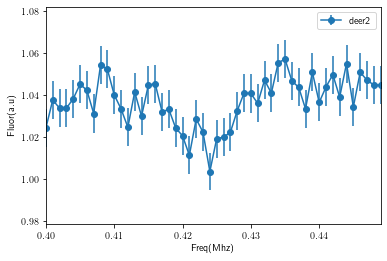

The DEER mw was tuned to 0.81000 GHz


In [66]:
f = datadir + '/deer2.txt' # note that there was a typo in the filename 
fg = plotsingledatafile(f,xaxis = 'Freq(Mhz)',yaxis=r'Fluor(a.u)')
a,b,c,d = getlogparams(f)
#print(a,b,c,d)
print("The DEER mw was tuned to {0:.5f} GHz".format(c['PTS'][1]))
fg.savefig("nv3_deer2.pdf",bbox_inches="tight")

The data below for spinecho is pretty interesting, there look to be oscillations , are these C13 oscillations, due to hyperfine interaction? 

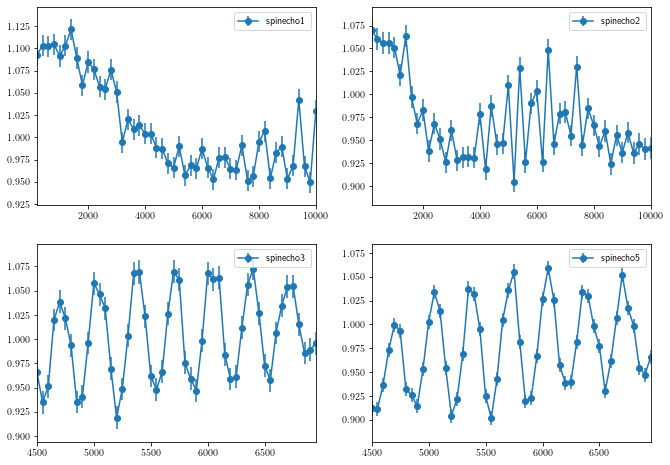

In [7]:
fig,axs = plotmatchdatafiles(datadir,'echo',xaxis=r'',yaxis='',plotrows=2,plotcols=2)

## NV3, 2018-02-02

In [67]:
datadir = dir_path + '/'+'2018-02-02'
flist = listlogfiles(datadir)

--------------log files in ./KaisData/PulsedESR/OneDrive_1_6-10-2021/2018-02-02--------
deerrabi1.log


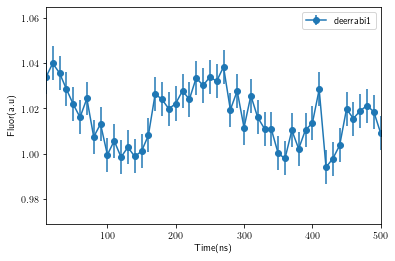

The DEER mw was tuned to 0.42300 GHz, NV was tuned to 2.45120 GHz


In [68]:
f = datadir + '/deerrabi1.txt'
fg = plotsingledatafile(f,xaxis = 'Time(ns)',yaxis=r'Fluor(a.u)')
a,b,c,d = getlogparams(f)
#print(a,b,c,d)
print("The DEER mw was tuned to {0:.5f} GHz, NV was tuned to {1:.5f} GHz".format(c['PTS'][1],c['USB'][1]))
fg.savefig("nv3_deerrabi_423MHz.pdf",bbox_inches="tight")

## NV4, 2018-08-17

Starting from these dates, something seems broken in the filenames, latex is complaining that the filenames cannot be processed with the underscore which is weird. I might have to go into the data & change all the filenames perhaps. But mostly the data seems to be ODMR and Rabi data and according to his lab notes these data were not used for the paper.

In [11]:
datadir = dir_path + '/'+'2018-08-17'
flist = listlogfiles(datadir)

--------------log files in ./KaisData/PulsedESR/OneDrive_1_6-10-2021/2018-08-17--------
300ns_scan.log


In [12]:
f = datadir + '/300ns_scan.txt'
fg = plotsingledatafile(f,xaxis = 'Time(ns)',yaxis='Fluor(a.u)')
#a,b,c,d = getlogparams(f)
#print(a,b,c,d)
#print("The DEER mw was tuned to {0:.5f} GHz, NV was tuned to {1:.5f} GHz".format(c['PTS'][1],c['USB'][1]))

RuntimeError: latex was not able to process the following string:
b'300ns_scan'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/gurudevdutt/.matplotlib/tex.cache/4d0677de2cb8c827793c92487d01301d.tex
LaTeX2e <2018-04-01> patch level 2
Babel <3.18> and hyphenation patterns for 84 language(s) loaded.
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2018/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/ts1enc.def
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2018/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2018/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2018/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2018/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2018/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./4d0677de2cb8c827793c92487d01301d.aux)
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...ize{10.000000}{12.500000}{\sffamily 300ns_
                                                  scan}
No pages of output.
Transcript written on 4d0677de2cb8c827793c92487d01301d.log.




<Figure size 432x288 with 1 Axes>

## NV4, 2018-08-28

In [13]:
datadir = dir_path + '/'+'2018-08-28'
flist = listlogfiles(datadir)

--------------log files in ./KaisData/PulsedESR/OneDrive_1_6-10-2021/2018-08-28--------
Rabi_b_1.log
Rabi_1.log
Rabi_2.log


In [14]:
f = datadir + '/Rabi_1.txt'
fg = plotsingledatafile(f,xaxis = 'Time(ns)',yaxis=r'Fluor(a.u)')

RuntimeError: latex was not able to process the following string:
b'Rabi_1'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/gurudevdutt/.matplotlib/tex.cache/287ceb6670edc5754e8abb8febc71c5f.tex
LaTeX2e <2018-04-01> patch level 2
Babel <3.18> and hyphenation patterns for 84 language(s) loaded.
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2018/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/ts1enc.def
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2018/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2018/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2018/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2018/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2018/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./287ceb6670edc5754e8abb8febc71c5f.aux)
(/usr/local/texlive/2018/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...size{10.000000}{12.500000}{\sffamily Rabi_
                                                  1}
No pages of output.
Transcript written on 287ceb6670edc5754e8abb8febc71c5f.log.




<Figure size 432x288 with 1 Axes>